# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next section.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></div>

## Perform standard imports and load datasets

In [56]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# for determining (p,q) orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# for ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose  
# for determining ARIMA orders
from pmdarima import auto_arima                              

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('../Data/co2_mm_mlo.csv')

### Inspect the data, create a DatetimeIndex

In [57]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


We need to combine two integer columns (year and month) into a DatetimeIndex. We can do this by passing a dictionary into <tt>pandas.to_datetime()</tt> with year, month and day values.<br>
For more information visit https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [59]:
# Add a "date" datetime column
df['date'] = pd.to_datetime({'year':df['year'],
                    'month':df['month'], 'day':1})

In [60]:
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


### Plot the source data

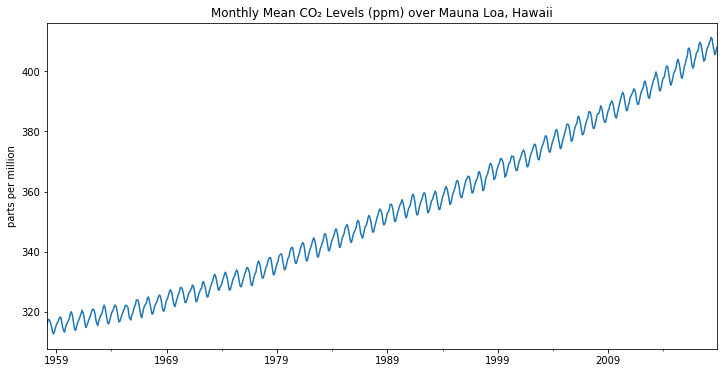

In [61]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

# We cant have a NaN value, so we will use interpolated column
ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

We can see clear seasonality, to confirm that we can run ETS decomposition.

### Run an ETS Decomposition to check seasonality

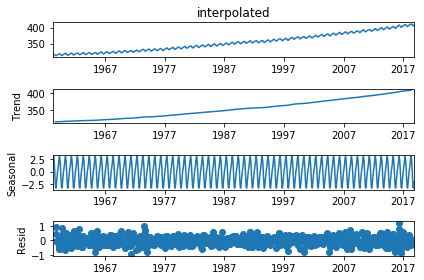

In [62]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

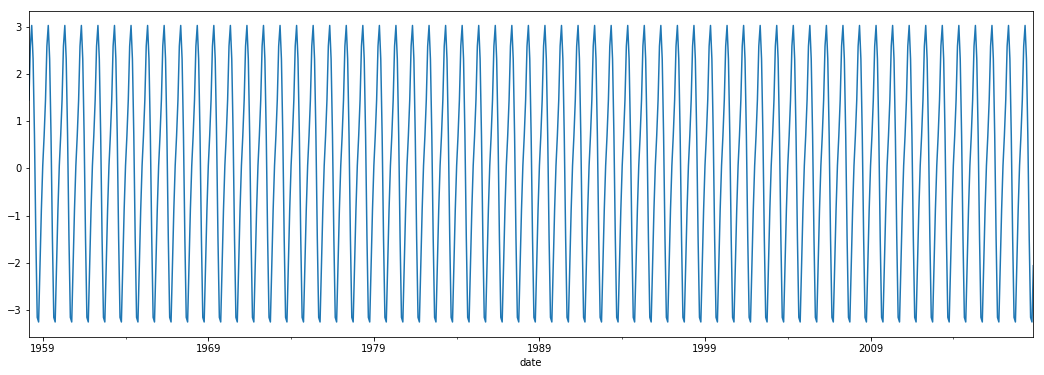

In [63]:
result.seasonal.plot(figsize=(18,6));

Although small in scale compared to the overall values, there is a definite annual seasonality. Last time we saw less seasonality so we used only ARIMA, so in test set, we saw the prediction just shows trend and no seasonality. So right way would be to consider seasonality even if it is relatively less.

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders i.e. pdq and PDQ
This may take awhile as there are a lot more combinations to evaluate.

In [64]:
# For SARIMA Orders we set seasonal=True and pass in an m value
# m is 12 because how many periods/rows per season in the data
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -209.587
Date:                            Wed, 03 Jun 2020   AIC                            429.174
Time:                                    19:01:30   BIC                            452.126
Sample:                                         0   HQIC                           438.030
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.995e-05      0.000      0.456      0.648      -0.000       0.000
ma.L1         -0.3763      0.034    -11.182      0.000      -0.442      -0.310
ar.S.L12       0.9995      0.000   2514.008      0.000       0.999       1.000
ma.S.L12      -0.8586      0.022    -38.480      0.000      -0.902      -0.815
sigma2         0.0960      0.005     20.357      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       51.07   Jarque-Bera (JB):                 3.56
Prob(Q):                              0.11   Prob(JB):                         0.17
Heteroskedasticity (H):               1.11   Skew:                            -0.04
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [65]:
len(df)

729

In [66]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

### Fit a SARIMA(0,1,3)(1,0,1,12) Model

In [67]:
# order is p,d,q
# seasonal order is P,D,Q
model = SARIMAX(train['interpolated'],
                order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.190
Date:                              Wed, 03 Jun 2020   AIC                            414.379
Time:                                      19:01:32   BIC                            441.821
Sample:                                  03-01-1958   HQIC                           424.976
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3541      0.035    -10.093      0.000      -0.423      -0.285
ma.L2         -0.0246      0.036     -0.687      0.492      -0.095       0.046
ma.L3         -0.0872      0.034     -2.537      0.011      -0.154      -0.020
ar.S.L12       0.9996      0.000   3016.992      0.000       0.999       1.000
ma.S.L12      -0.8656      0.023    -38.243      0.000      -0.910      -0.821
sigma2         0.0951      0.005     20.288      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       43.92   Jarque-Bera (JB):                 4.32
Prob(Q):                              0.31   Prob(JB):                         0.12
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=start, end=end, 
                        dynamic=False, typ='levels').\
            rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [69]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10},\
          expected={test['interpolated'][i]}")

predicted=406.6101955,          expected=406.81
predicted=407.825588 ,          expected=407.96
predicted=408.5792238,          expected=408.32
predicted=409.4842907,          expected=409.41
predicted=411.0417406,          expected=410.24
predicted=411.644938 ,          expected=411.24
predicted=410.8646299,          expected=410.79
predicted=409.1742445,          expected=408.71
predicted=407.0739557,          expected=406.99
predicted=405.62385  ,          expected=405.51
predicted=405.8946362,          expected=406.0
predicted=407.4285636,          expected=408.02


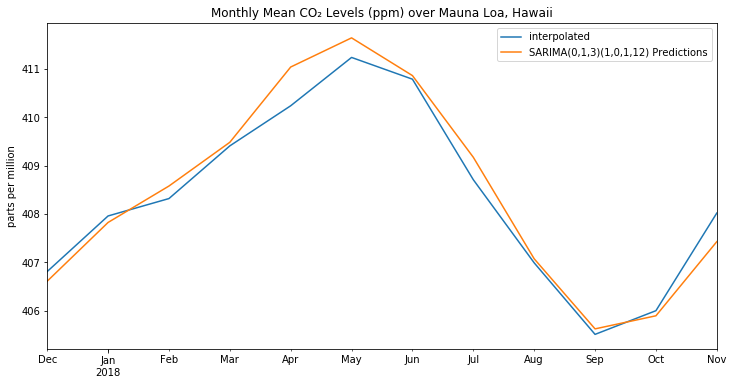

In [70]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),
                                                   title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate the Model

In [71]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1282890636


In [72]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3581746272


In [73]:
# COMPARE with real value
test['interpolated'].mean()

408.3333333333333

These are outstanding results! Root mean square error is in fractions where as actual magnitude of the `test['interpolated']` is in hundreds.
### Retrain the model on the full data, and forecast the future

In [74]:
model = SARIMAX(df['interpolated'],order=(0,1,3),
                            seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').\
                    rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

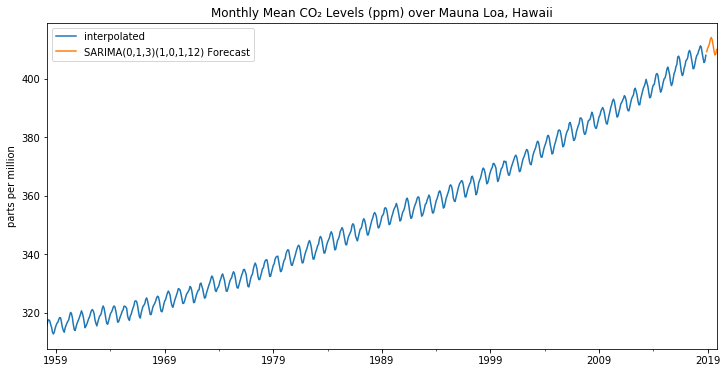

In [75]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),
                                                 title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);